In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
'''0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed'''
import time

import tensorflow as tf

from config import argparser
from data import get_dataloader
from model import Base, DIN, DIEN
from utils import eval
import matplotlib.pyplot as plt

# Config
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

args = argparser()

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [2]:
# Data Load
train_data, test_data, \
user_count, item_count, cate_count, \
cate_list = get_dataloader(args.train_batch_size, args.test_batch_size)

# Loss, Optim
optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr, momentum=0.0)
loss_metric = tf.keras.metrics.Sum()
auc_metric = tf.keras.metrics.AUC()

# Model
model1 = DIN(user_count, item_count, cate_count, cate_list,
             args.user_dim, args.item_dim, args.cate_dim, args.dim_layers)

model2 = DIEN(user_count, item_count, cate_count, cate_list,
             args.user_dim, args.item_dim, args.cate_dim, args.dim_layers)

# Board
train_summary_writer = tf.summary.create_file_writer(args.log_path)

In [3]:
#@tf.function
def train_one_step(u,i,y,hist_i,sl, model):
    with tf.GradientTape() as tape:
        output,_ = model(u,i,hist_i,sl)
        loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=tf.cast(y, dtype=tf.float32)))
    gradient = tape.gradient(loss, model.trainable_variables)
    clip_gradient, _ = tf.clip_by_global_norm(gradient, 5.0)
    optimizer.apply_gradients(zip(clip_gradient, model.trainable_variables))

    loss_metric(loss)

In [4]:
# Train
def train(optimizer, model):
    best_loss= 0.
    best_auc = 0.
    start_time = time.time()
    
    for epoch in range(args.epochs):
        for step, (u, i, y, hist_i, sl) in enumerate(train_data, start=1):
            train_one_step(u, i, y, hist_i, sl, model)

            if step % args.print_step == 0:
                test_gauc, auc = eval(model, test_data)
                print('Epoch %d Global_step %d\tTrain_loss: %.4f\tEval_GAUC: %.4f\tEval_AUC: %.4f' %
                      (epoch, step, loss_metric.result()/ args.print_step, test_gauc, auc))
                
                loss_his.append(loss_metric.result()/ args.print_step)
                auc_his.append(auc)
                test_gauc_his.append(test_gauc)

                if best_auc < test_gauc:
                    best_loss= loss_metric.result() / args.print_step
                    best_auc = test_gauc
                    model.save_weights(args.model_path+'cp-%d.ckpt'%epoch)
                loss_metric.reset_states()

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', best_loss, step=epoch)
            tf.summary.scalar('test_gauc', best_auc, step=epoch)

        loss_metric.reset_states()
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
        print('Epoch %d DONE\tCost time: %.2f' % (epoch, time.time()-start_time))
    print('Best test_gauc: ', best_auc)

Epoch 0 Global_step 100	Train_loss: 0.6915	Eval_GAUC: 0.6983	Eval_AUC: 0.6636
Epoch 0 DONE	Cost time: 3.08
Epoch 1 Global_step 100	Train_loss: 0.6862	Eval_GAUC: 0.7213	Eval_AUC: 0.6789
Epoch 1 DONE	Cost time: 5.93
Epoch 2 Global_step 100	Train_loss: 0.6812	Eval_GAUC: 0.7184	Eval_AUC: 0.6816
Epoch 2 DONE	Cost time: 8.68
Epoch 3 Global_step 100	Train_loss: 0.6766	Eval_GAUC: 0.7184	Eval_AUC: 0.6819
Epoch 3 DONE	Cost time: 11.41
Epoch 4 Global_step 100	Train_loss: 0.6722	Eval_GAUC: 0.7098	Eval_AUC: 0.6821
Epoch 4 DONE	Cost time: 14.11
Epoch 5 Global_step 100	Train_loss: 0.6680	Eval_GAUC: 0.7126	Eval_AUC: 0.6820
Epoch 5 DONE	Cost time: 16.81
Epoch 6 Global_step 100	Train_loss: 0.6640	Eval_GAUC: 0.7126	Eval_AUC: 0.6817
Epoch 6 DONE	Cost time: 19.51
Epoch 7 Global_step 100	Train_loss: 0.6601	Eval_GAUC: 0.7098	Eval_AUC: 0.6818
Epoch 7 DONE	Cost time: 22.21
Epoch 8 Global_step 100	Train_loss: 0.6562	Eval_GAUC: 0.7040	Eval_AUC: 0.6818
Epoch 8 DONE	Cost time: 24.91
Epoch 9 Global_step 100	Train_l

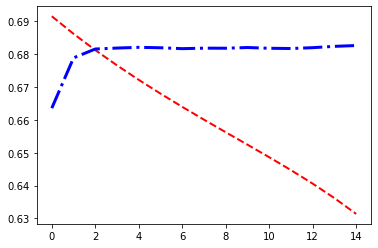

In [5]:
loss_his = []
auc_his = []
test_gauc_his = []

train(optimizer, model1) # DIN

plt.plot(loss_his,color='red',linewidth=2.0,linestyle='--')
plt.plot(auc_his,color='blue',linewidth=3.0,linestyle='-.')
plt.show()


Epoch 0 Global_step 100	Train_loss: 0.7033	Eval_GAUC: 0.7184	Eval_AUC: 0.6791
Epoch 0 DONE	Cost time: 6.87
Epoch 1 Global_step 100	Train_loss: 0.6896	Eval_GAUC: 0.7126	Eval_AUC: 0.6803
Epoch 1 DONE	Cost time: 12.85
Epoch 2 Global_step 100	Train_loss: 0.6849	Eval_GAUC: 0.7155	Eval_AUC: 0.6810
Epoch 2 DONE	Cost time: 18.91
Epoch 3 Global_step 100	Train_loss: 0.6805	Eval_GAUC: 0.7155	Eval_AUC: 0.6818
Epoch 3 DONE	Cost time: 25.05
Epoch 4 Global_step 100	Train_loss: 0.6764	Eval_GAUC: 0.7155	Eval_AUC: 0.6822
Epoch 4 DONE	Cost time: 31.09
Epoch 5 Global_step 100	Train_loss: 0.6726	Eval_GAUC: 0.7155	Eval_AUC: 0.6825
Epoch 5 DONE	Cost time: 37.17
Epoch 6 Global_step 100	Train_loss: 0.6689	Eval_GAUC: 0.7155	Eval_AUC: 0.6827
Epoch 6 DONE	Cost time: 43.25
Epoch 7 Global_step 100	Train_loss: 0.6655	Eval_GAUC: 0.7184	Eval_AUC: 0.6829
Epoch 7 DONE	Cost time: 49.22
Epoch 8 Global_step 100	Train_loss: 0.6623	Eval_GAUC: 0.7184	Eval_AUC: 0.6828
Epoch 8 DONE	Cost time: 55.25
Epoch 9 Global_step 100	Train

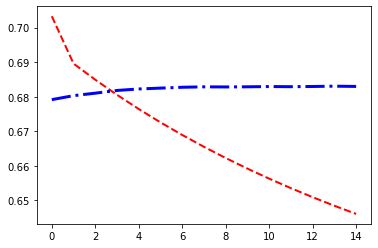

In [6]:
loss_his = []
auc_his = []
test_gauc_his = []

train(optimizer, model2) # DIEN

plt.plot(loss_his,color='red',linewidth=2.0,linestyle='--')
plt.plot(auc_his,color='blue',linewidth=3.0,linestyle='-.')
plt.show()